In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats

!whoami
!date

alibow
Mon Jun 29 15:57:31 PDT 2020


In [2]:
# add list here when complete :) 

output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/india/2020_06_26_20_35_00/count_data/',
              '/share/costeffectiveness/results/vivarium_conic_lsff/nigeria/2020_06_26_20_28_27/count_data/']

locations = ['India','Nigeria']

In [3]:
def get_stratified_averted_results(strata_cols):
    master_data = pd.DataFrame()
    master_pt = pd.DataFrame()
    for i in range(len(output_dirs)):
        data = pd.DataFrame()
        for measure in ['deaths','ylls','ylds']:
            temp = pd.read_hdf(output_dirs[i] + measure + '.hdf')
            temp['measure'] = measure
            data = data.append(temp)
        data['location'] = locations[i]
        master_data = master_data.append(data)
        pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
        pt = pt.loc[pt.cause.str.contains('diarrheal')]
        pt['location'] = locations[i]
        master_pt = master_pt.append(pt)
    # remove 2020 from dataset if not stratifying by year
    if 'year' not in strata_cols:
        master_data = master_data.loc[master_data.year != '2020']
    master_data = master_data.groupby((['location','scenario','input_draw'] + strata_cols + ['measure'])).sum()
    if 'cause' in strata_cols:
        no_cause_strata_cols = [col for col in strata_cols if col != 'cause']
        master_pt = master_pt.groupby(['location','scenario','input_draw'] + no_cause_strata_cols).sum()
    else:    
        master_pt = master_pt.groupby((['location','scenario','input_draw'] + strata_cols)).sum()
    rates = master_data / master_pt
    baseline_rates = rates.reset_index()
    baseline_rates = baseline_rates.loc[baseline_rates.scenario == 'baseline']
    baseline_rates = baseline_rates.set_index((['location','input_draw'] + strata_cols + ['measure'])).drop(columns='scenario')
    rates = rates.reset_index().set_index((['location','input_draw'] + strata_cols + ['measure','scenario']))
    averted_rates = (baseline_rates - rates) * 100_000
    averted_rates = averted_rates.reset_index()
    averted_rates = averted_rates.loc[averted_rates.scenario != 'baseline']
    return averted_rates

In [4]:
overall = get_stratified_averted_results([])
overall.head()

,location,input_draw,measure,scenario,value
1,India,21,deaths,folic_acid_fortification_scale_up,0.000000
2,India,21,deaths,iron_folic_acid_fortification_scale_up,0.000000
3,India,21,deaths,vitamin_a_fortification_scale_up,2.245597
5,India,21,ylds,folic_acid_fortification_scale_up,0.005643
6,India,21,ylds,iron_folic_acid_fortification_scale_up,11.787625


In [5]:
by_year = get_stratified_averted_results(['year'])
by_year.head()

,location,input_draw,year,measure,scenario,value
1,India,21,2020,deaths,folic_acid_fortification_scale_up,1.734723e-13
2,India,21,2020,deaths,iron_folic_acid_fortification_scale_up,2.602085e-13
3,India,21,2020,deaths,vitamin_a_fortification_scale_up,1.734723e-13
5,India,21,2020,ylds,folic_acid_fortification_scale_up,6.938894e-13
6,India,21,2020,ylds,iron_folic_acid_fortification_scale_up,2.081668e-12


In [6]:
by_cause = get_stratified_averted_results(['cause'])
by_cause.head()

,location,input_draw,cause,measure,scenario,value
1,India,21,diarrheal_diseases,deaths,folic_acid_fortification_scale_up,0.000000e+00
2,India,21,diarrheal_diseases,deaths,iron_folic_acid_fortification_scale_up,0.000000e+00
3,India,21,diarrheal_diseases,deaths,vitamin_a_fortification_scale_up,1.509529e+00
5,India,21,diarrheal_diseases,ylds,folic_acid_fortification_scale_up,-2.168404e-14
6,India,21,diarrheal_diseases,ylds,iron_folic_acid_fortification_scale_up,-2.168404e-14


In [7]:
by_year_and_cause = get_stratified_averted_results(['year','cause'])
by_year_and_cause.head()

,location,input_draw,year,cause,measure,scenario,value
1,India,21,2020,diarrheal_diseases,deaths,folic_acid_fortification_scale_up,1.084202e-14
2,India,21,2020,diarrheal_diseases,deaths,iron_folic_acid_fortification_scale_up,2.168404e-14
3,India,21,2020,diarrheal_diseases,deaths,vitamin_a_fortification_scale_up,1.084202e-14
5,India,21,2020,diarrheal_diseases,ylds,folic_acid_fortification_scale_up,2.168404e-14
6,India,21,2020,diarrheal_diseases,ylds,iron_folic_acid_fortification_scale_up,4.336809e-14


In [8]:
def plot_results_by_cause(dataset, scenarios, outcome_vars, causes):
    for scenario in scenarios:
        for cause in causes:
            for outcome_var in outcome_vars:
                
                if outcome_var == 'dalys':
                    outcome_name_long = 'Disability Adjusted Life Years'
                    outcome_name_short = 'DALYs'
                elif outcome_var == 'ylls':
                    outcome_name_long = 'Years of Life Lost'
                    outcome_name_short = 'YLLs'
                elif outcome_var == 'ylds':
                    outcome_name_long = 'Years Lived with Disability'
                    outcome_name_short = 'YLDs'
                else:
                    outcome_name_long = 'Deaths'
                    outcome_name_short = 'Deaths'
                
                data = dataset.loc[dataset.scenario == scenario]
                data = data.loc[data.cause == cause]
                
                if outcome_var == 'dalys':
                    data = data.loc[data.measure.isin(['ylls','ylds'])]
                    data = data.groupby(['location','input_draw']).sum()
                else:
                    data = data.loc[data.measure == outcome_var]
                
                data = data.groupby(['location']).describe().reset_index().set_index('location')

                pos1 = 0.2
                pos2 = 0.4
                pos3 = 0.6    

                fig, ax = plt.subplots(figsize=(7.5, 5))

                plt.plot([(pos1 - 0.1),(pos3 + 0.1)],[0,0],'--',c='grey')

                plt.plot([pos1,pos1],[data['value','min'][0],data['value','max'][0]],c='black')
                plt.plot([pos2,pos2],[data['value','min'][1],data['value','max'][1]],c='black')
                #plt.plot([pos3,pos3],[data['value','min'][2],data['value','max'][2]],c='black')
                #plt.scatter([pos1,pos2,pos3],data['value','min'], marker='_',c='black',s=50)
                #plt.scatter([pos1,pos2,pos3],data['value','max'], marker='_',c='black',s=50)         
                #plt.scatter([pos1,pos2,pos3],data['value','mean'], s=100)

                #rewritten for india and nigeria only
                plt.scatter([pos1,pos2],data['value','min'], marker='_',c='black',s=50)
                plt.scatter([pos1,pos2],data['value','max'], marker='_',c='black',s=50)         
                plt.scatter([pos1,pos2],data['value','mean'], s=100)

                scenario_title = scenario.replace('_',' ').capitalize()
                cause_title = cause.replace('_',' ').capitalize()

                plt.xticks([pos1,pos2,pos3], data.index)
                if outcome_var == 'deaths':
                    plt.title(f'{scenario_title}\n{outcome_name_long} due to {cause_title} Averted per 100,000 Person-Years')
                else:
                    plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) due to {cause_title}\n Averted per 100,000 Person-Years')
                plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
                plt.tight_layout()
                plt.savefig(f'dot_plot_{scenario}_{cause}_{outcome_var}')

In [9]:
def make_multiple_plots_by_year_and_cause(dataset, scenarios, causes, outcome_vars):
    for scenario in scenarios:
        for outcome_var in outcome_vars:
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'
            for cause in causes:

                data = dataset.loc[dataset.scenario == scenario]
                data = dataset.loc[dataset.cause == cause]
                if outcome_var == 'dalys':
                    data = data.loc[data.measure.isin(['ylds','ylls'])]
                    data = data.groupby(['location','year','input_draw'], as_index=False).sum()
                else:
                    data = data.loc[data.measure == outcome_var]
                data = data.groupby(['location','year']).describe().reset_index()

                ethiopia = data.loc[data.location == 'Ethiopia']
                india = data.loc[data.location == 'India']
                nigeria = data.loc[data.location == 'Nigeria']

                fig, ax = plt.subplots(figsize=(7.5, 5))

                plt.scatter(ethiopia['year'], ethiopia['value','mean'])
                plt.plot(ethiopia['year'], ethiopia['value','mean'])

                plt.scatter(india['year'], india['value','mean'])
                plt.plot(india['year'], india['value','mean'])

                plt.scatter(nigeria['year'], nigeria['value','mean'])
                plt.plot(nigeria['year'], nigeria['value','mean'])

                plt.fill_between(ethiopia['year'],ethiopia['value','max'],ethiopia['value','min'], alpha=0.3,color='tab:blue')
                plt.fill_between(india['year'],india['value','max'],india['value','min'], alpha=0.3,color='tab:orange')
                plt.fill_between(nigeria['year'],nigeria['value','max'],nigeria['value','min'], alpha=0.3,color='tab:green')

                scenario_title = scenario.replace('_',' ').capitalize()
                cause_title = cause.replace('_',' ').capitalize()

                plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) due to {cause_title} Averted per 100,000 Person-Years')
                plt.legend(['Ethiopia','India','Nigeria'])
                plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
                plt.tight_layout()
                plt.savefig(f'{scenario}_{cause}_{outcome_var}_by_year.png')

In [10]:
def make_multiple_plots_by_year_with_uncertainty(dataset, scenarios, outcome_vars):
    for scenario in scenarios:
        for outcome_var in outcome_vars:
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'

            data = dataset.loc[dataset.scenario == scenario]
            if outcome_var == 'dalys':
                data = data.loc[data.measure.isin(['ylds','ylls'])]
                data = data.groupby(['location','year','input_draw'], as_index=False).sum()
            else:
                data = data.loc[data.measure == outcome_var]
            data = data.groupby(['location','year']).describe().reset_index()

            ethiopia = data.loc[data.location == 'Ethiopia']
            india = data.loc[data.location == 'India']
            nigeria = data.loc[data.location == 'Nigeria']

            fig, ax = plt.subplots(figsize=(7.5, 5))
            
            plt.scatter(ethiopia['year'], ethiopia['value','mean'])
            plt.plot(ethiopia['year'], ethiopia['value','mean'])

            plt.scatter(india['year'], india['value','mean'])
            plt.plot(india['year'], india['value','mean'])

            plt.scatter(nigeria['year'], nigeria['value','mean'])
            plt.plot(nigeria['year'], nigeria['value','mean'])
            
            plt.fill_between(ethiopia['year'],ethiopia['value','max'],ethiopia['value','min'], alpha=0.3,color='tab:blue')
            plt.fill_between(india['year'],india['value','max'],india['value','min'], alpha=0.3,color='tab:orange')
            plt.fill_between(nigeria['year'],nigeria['value','max'],nigeria['value','min'], alpha=0.3,color='tab:green')
            
            scenario_title = scenario.replace('_',' ').capitalize()

            plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.legend(['Ethiopia','India','Nigeria'])
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
            plt.tight_layout()
            plt.savefig(f'{scenario}_overall_{outcome_var}_by_location.png')

In [11]:
def make_multiple_plots_by_year_by_location(dataset, locations, outcome_vars):
    for location in locations:
        for outcome_var in outcome_vars:
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'

            data = dataset.loc[dataset.location == location]
            if outcome_var == 'dalys':
                data = data.loc[data.measure.isin(['ylds','ylls'])]
                data = data.groupby(['scenario','year','input_draw'], as_index=False).sum()
            else:
                data = data.loc[data.measure == outcome_var]
            data = data.groupby(['scenario','year']).describe().reset_index()

            vitamin_a = data.loc[data.scenario == 'vitamin_a_fortification_scale_up']
            folic_acid = data.loc[data.scenario == 'folic_acid_fortification_scale_up']
            iron_folic_acid = data.loc[data.scenario == 'iron_folic_acid_fortification_scale_up']

            fig, ax = plt.subplots(figsize=(7.5, 5))
            
            plt.scatter(vitamin_a['year'], vitamin_a['value','mean'])
            plt.plot(vitamin_a['year'], vitamin_a['value','mean'])

            plt.scatter(folic_acid['year'], folic_acid['value','mean'])
            plt.plot(folic_acid['year'], folic_acid['value','mean'])

            plt.scatter(iron_folic_acid['year'], iron_folic_acid['value','mean'])
            plt.plot(iron_folic_acid['year'], iron_folic_acid['value','mean'])
            
            plt.fill_between(vitamin_a['year'],vitamin_a['value','max'],vitamin_a['value','min'], alpha=0.3,color='tab:blue')
            plt.fill_between(folic_acid['year'],folic_acid['value','max'],folic_acid['value','min'], alpha=0.3,color='tab:orange')
            plt.fill_between(iron_folic_acid['year'],iron_folic_acid['value','max'],iron_folic_acid['value','min'], alpha=0.3,color='tab:green')
            
            plt.title(f'{location}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.legend(['Vitamin A Fortification','Folic Acid Fortification','Iron Fortification'])
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')
            plt.tight_layout()
            plt.savefig(f'{location}_overall_{outcome_var}_by_scenario.png')

In [12]:
def make_multiple_dot_plots(dataset, scenarios, outcome_vars):
    
    for scenario in scenarios:
        for outcome_var in outcome_vars:
    
            data = dataset.loc[dataset.scenario == scenario]
            if outcome_var == 'dalys':
                data = data.loc[data.measure.isin(['ylds','ylls'])]
                data = data.groupby(['location','input_draw']).sum()
            else:
                data = data.loc[data.measure == outcome_var]
            data = data.groupby(['location']).describe()
    
            if outcome_var == 'dalys':
                outcome_name_long = 'Disability Adjusted Life Years'
                outcome_name_short = 'DALYs'
            elif outcome_var == 'ylls':
                outcome_name_long = 'Years of Life Lost'
                outcome_name_short = 'YLLs'
            elif outcome_var == 'ylds':
                outcome_name_long = 'Years Lived with Disability'
                outcome_name_short = 'YLDs'
            else:
                outcome_name_long = 'Deaths'
                outcome_name_short = 'Deaths'
        
            pos1 = 0.2
            pos2 = 0.4
            pos3 = 0.6    
            
            fig, ax = plt.subplots(figsize=(7.5, 5))

            plt.plot([(pos1 - 0.1),(pos3 + 0.1)],[0,0],'--',c='grey')

            plt.plot([pos1,pos1],[data['value','min'][0],data['value','max'][0]],c='black')
            plt.plot([pos2,pos2],[data['value','min'][1],data['value','max'][1]],c='black')
            #plt.plot([pos3,pos3],[data['value','min'][2],data['value','max'][2]],c='black')
            #plt.scatter([pos1,pos2,pos3],data['value','min'], marker='_',c='black',s=50)
            #plt.scatter([pos1,pos2,pos3],data['value','max'], marker='_',c='black',s=50)         
            #plt.scatter([pos1,pos2,pos3],data['value','mean'], s=100)
            
            #rewritten for india and nigeria only
            plt.scatter([pos1,pos2],data['value','min'], marker='_',c='black',s=50)
            plt.scatter([pos1,pos2],data['value','max'], marker='_',c='black',s=50)         
            plt.scatter([pos1,pos2],data['value','mean'], s=100)
            
            scenario_title = scenario.replace('_',' ').capitalize()

            plt.xticks([pos1,pos2,pos3], data.index)
            if outcome_var == 'deaths':
                plt.title(f'{scenario_title}\n{outcome_name_long} Averted per 100,000 Person-Years')
            else:
                plt.title(f'{scenario_title}\n{outcome_name_long} ({outcome_name_short}) Averted per 100,000 Person-Years')
            plt.ylabel(f'{outcome_name_short} Averted per 100,000 PY')

In [13]:
def make_averted_outcome_bar_chart_for_each_location_and_scenario(measure):
    
    data = pd.DataFrame.copy(overall)
    
    # bar width
    barWidth = 0.25
    
    if measure == 'dalys':
        data = data.loc[data.measure.isin(['ylds','ylls'])]
        data = data.groupby(['location','scenario','input_draw']).sum()
    else:    
        data = data.loc[data.measure == measure]
        
    data = data.groupby(['location','scenario']).describe().reset_index().sort_values(by='location')
    data1 = data.loc[data.scenario == 'vitamin_a_fortification_scale_up']
    data2 = data.loc[data.scenario == 'folic_acid_fortification_scale_up']
    data3 = data.loc[data.scenario == 'iron_folic_acid_fortification_scale_up']

    data1_mean = data1['value','mean']
    data1_min = data1['value','mean'] - data1['value','min']
    data1_max = data1['value','max'] - data1['value','mean']

    data2_mean = data2['value','mean']
    data2_min = data2['value','mean'] - data2['value','min']
    data2_max = data2['value','max'] - data2['value','mean']

    data3_mean = data3['value','mean']
    data3_min = data3['value','mean'] - data3['value','min']
    data3_max = data3['value','max'] - data3['value','mean']

    a = np.arange(len(data1))
    b = [x + barWidth for x in a]
    c = [x + barWidth for x in b]

    plt.bar(a, data1_mean, width=barWidth, yerr = [data1_max, data1_min])
    plt.bar(b, data2_mean, width=barWidth, yerr = [data2_max, data2_min])
    plt.bar(c, data3_mean, width=barWidth, yerr = [data3_max, data3_min])
    
    if measure == 'dalys':
        measure_title = 'Disability Adjusted Life Years (DALYs)'
    elif measure == 'ylds':
        measure_title = 'Years Lived With Disability (YLDs)'
    elif measure == 'ylls':
        measure_title = 'Years of Life Lost (YLLs)'
    else:
        measure_title = 'Deaths'
    
    plt.xticks([r + barWidth for r in range(len(data1))], np.unique(data1['location']))
    plt.ylabel(f'{measure_title}\n Averted per 100,000 PYs')
    plt.legend(['Vitamin A',
               'Folic Acid',
               'Iron Folic Acid'])
    plt.title(f'{measure_title} Averted \n per 100,000 Person-Years')
    plt.tight_layout()
    plt.savefig(f'bar_chart_{measure}_averted_for_each_location_and_scenario')

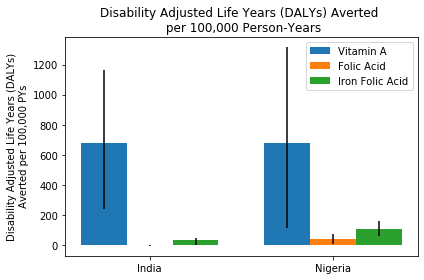

In [14]:
make_averted_outcome_bar_chart_for_each_location_and_scenario('dalys')

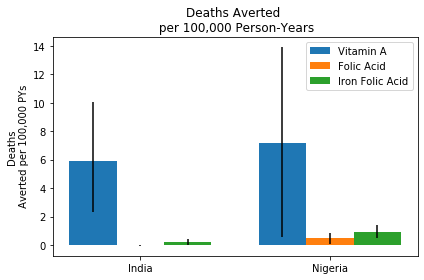

In [15]:
make_averted_outcome_bar_chart_for_each_location_and_scenario('deaths')

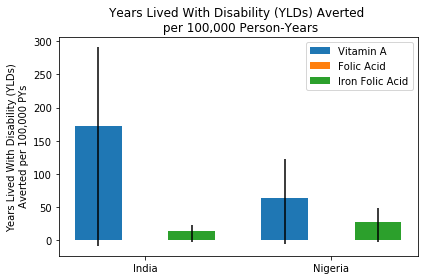

In [16]:
make_averted_outcome_bar_chart_for_each_location_and_scenario('ylds')

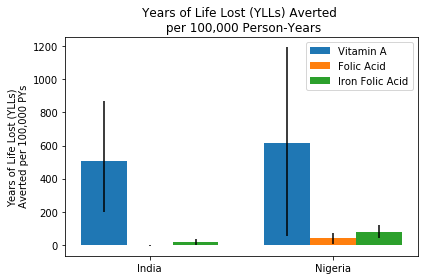

In [17]:
make_averted_outcome_bar_chart_for_each_location_and_scenario('ylls')

In [22]:
def make_dalys_averted_bar_chart_for_single_scenario(scenario):
    
    data = overall.loc[overall.scenario == scenario]
    dalys = data.loc[data.measure.isin(['ylds','ylls'])]
    dalys = dalys.groupby(['location','scenario']).describe().reset_index().sort_values(by='location')
    a = np.arange(len(dalys))
    plt.bar(a, dalys['value','mean'], yerr=dalys['value','std'])
    
    scenario_title = scenario.replace('_',' ').capitalize()

    plt.xticks([r for r in range(len(dalys))], np.unique(dalys['location']))
    plt.ylabel('DALYs Averted per 100,000 Person Years')
    plt.title(f'{scenario_title}\n Disability Adjusted Life Years (DALYs)\n Averted per 100,000 Person Years')
    plt.tight_layout()
    plt.savefig(f'bar_chart_dalys_averted_{scenario}')

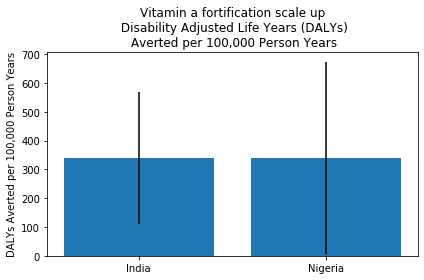

In [23]:
make_dalys_averted_bar_chart_for_single_scenario('vitamin_a_fortification_scale_up')

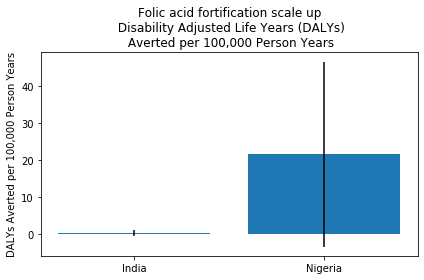

In [24]:
make_dalys_averted_bar_chart_for_single_scenario('folic_acid_fortification_scale_up')

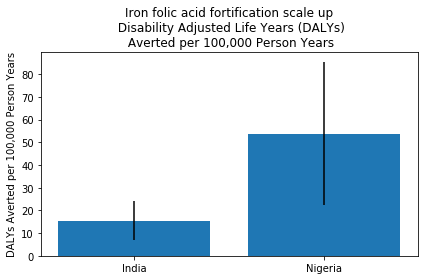

In [25]:
make_dalys_averted_bar_chart_for_single_scenario('iron_folic_acid_fortification_scale_up')

In [26]:
def make_stacked_bar_chart_for_single_scenario(scenario):
    
    data = overall.loc[overall.scenario == scenario]
    ylds = data.loc[data.measure == 'ylds']
    ylds = ylds.groupby(['location','scenario']).describe().reset_index().sort_values(by='location')
    dalys = data.loc[data.measure.isin(['ylds','ylls'])]
    dalys = dalys.groupby(['location','scenario']).describe().reset_index().sort_values(by='location')
    a = np.arange(len(ylds))
    plt.bar(a, dalys['value','mean'], yerr=dalys['value','std'])
    plt.bar(a, ylds['value','mean'])

    scenario_title = scenario.replace('_',' ').capitalize()
    
    plt.xticks([r for r in range(len(ylds))], np.unique(ylds['location']))
    plt.ylabel('DALYs Averted per 100,000 Person Years')
    plt.title(f'{scenario_title}\n Disability Adjusted Life Years (DALYs)\n Averted per 100,000 Person Years')
    plt.legend(['YLLs','YLDs'])
    plt.tight_layout()
    plt.savefig(f'bar_chart_stacked_dalys_averted_{scenario}')

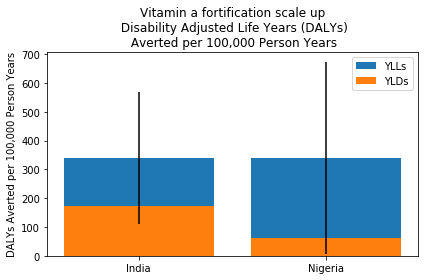

In [27]:
make_stacked_bar_chart_for_single_scenario('vitamin_a_fortification_scale_up')

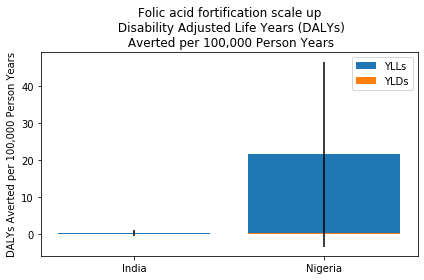

In [28]:
make_stacked_bar_chart_for_single_scenario('folic_acid_fortification_scale_up')

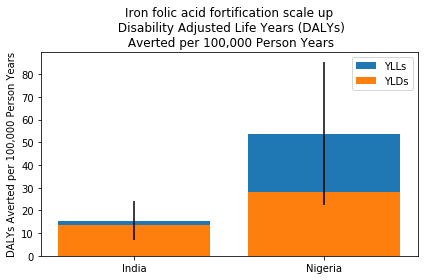

In [29]:
make_stacked_bar_chart_for_single_scenario('iron_folic_acid_fortification_scale_up')


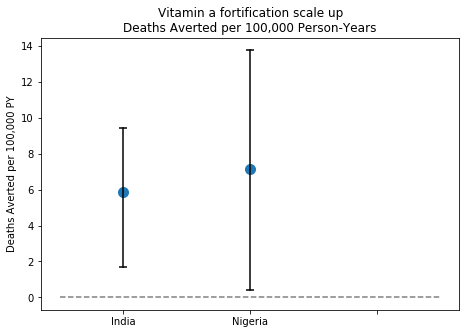

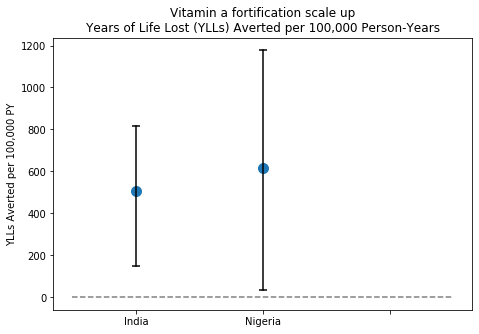

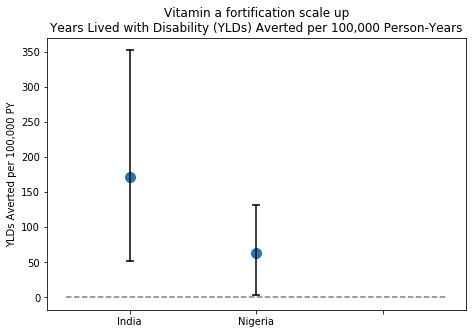

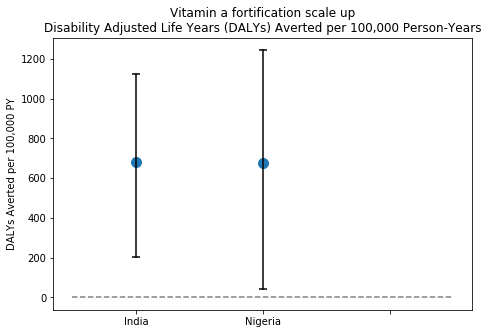

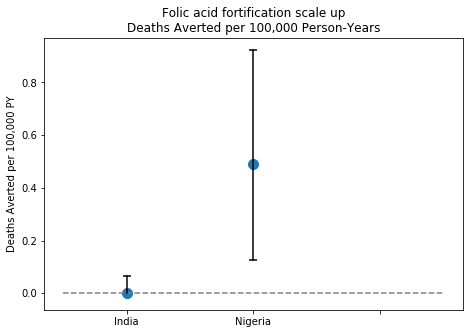

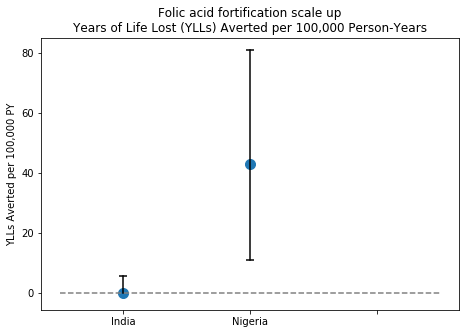

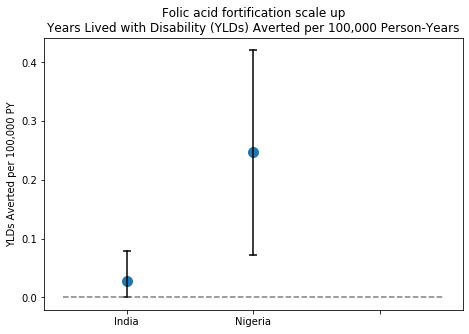

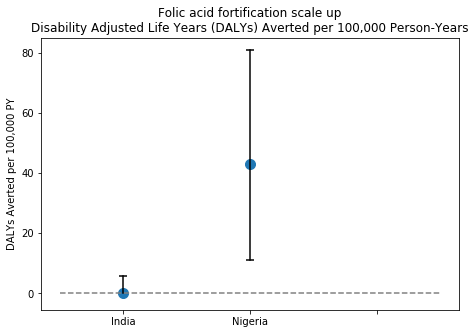

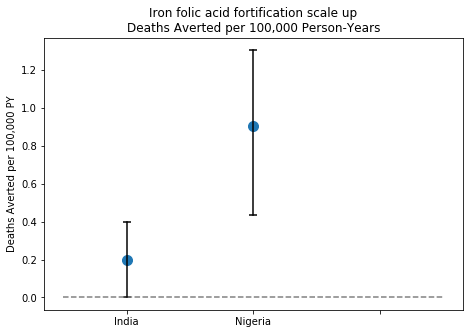

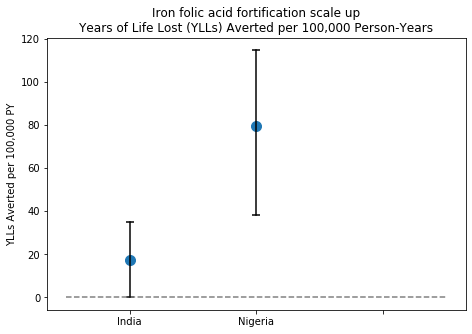

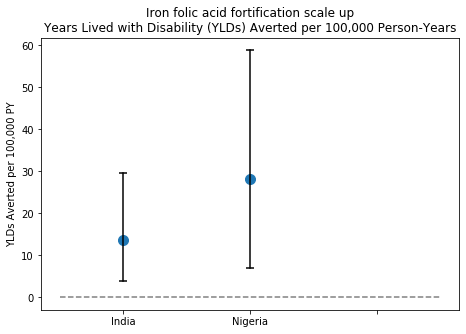

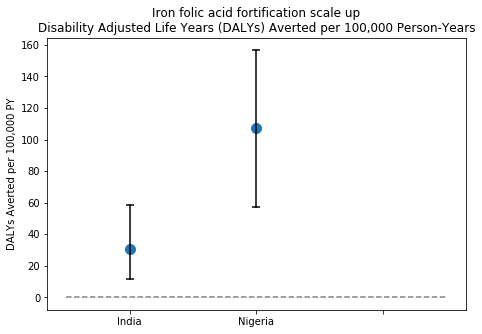

In [30]:
scenarios = ['vitamin_a_fortification_scale_up','folic_acid_fortification_scale_up',
            'iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_dot_plots(overall, scenarios, outcome_vars)

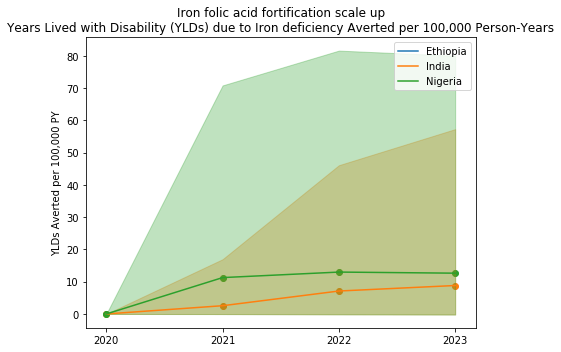

In [31]:
# IRON/IRON DEFICIENCY YLDS BY YEAR

scenarios = ['iron_folic_acid_fortification_scale_up']
causes = ['iron_deficiency']
outcome_vars = ['ylds']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

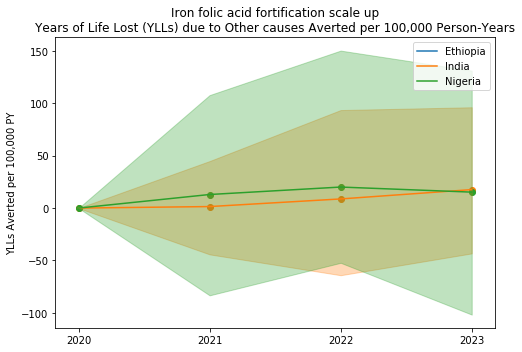

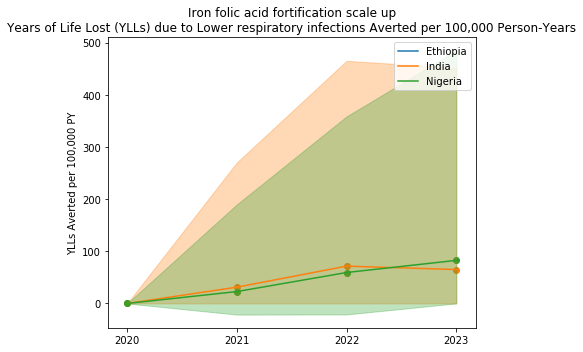

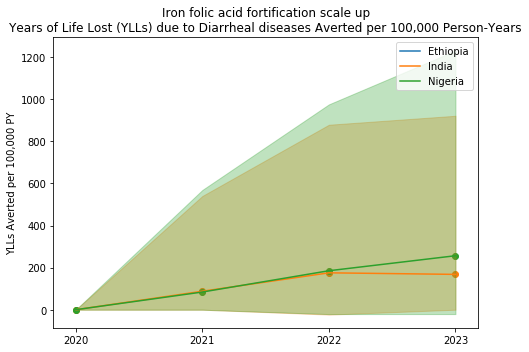

In [32]:
# IRON AFFECTED CAUSES YLLs BY YEAR

scenarios = ['iron_folic_acid_fortification_scale_up']
causes = ['other_causes','lower_respiratory_infections','diarrheal_diseases']
outcome_vars = ['ylls']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

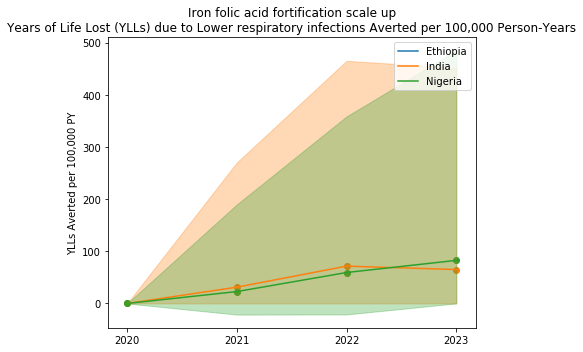

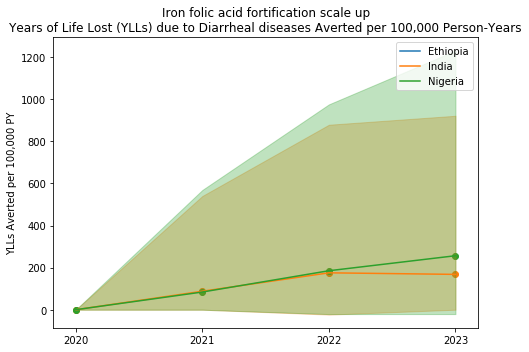

In [33]:
# IRON AFFECTED CAUSES YLDs BY YEAR

scenarios = ['iron_folic_acid_fortification_scale_up']
causes = ['lower_respiratory_infections','diarrheal_diseases']
outcome_vars = ['ylls']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

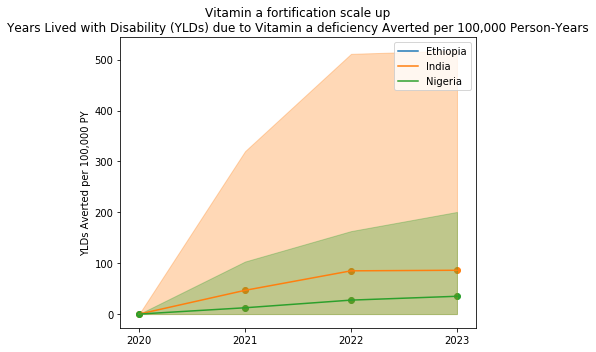

In [34]:
# VITAMIN A DEFICIENCY YLDS BY YEAR

scenarios = ['vitamin_a_fortification_scale_up']
causes = ['vitamin_a_deficiency']
outcome_vars = ['ylds']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

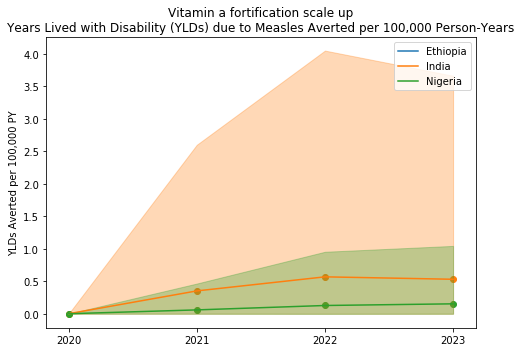

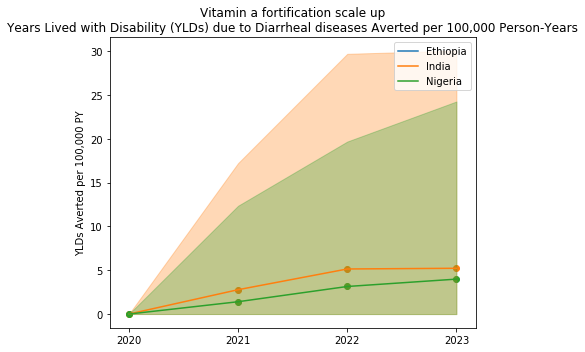

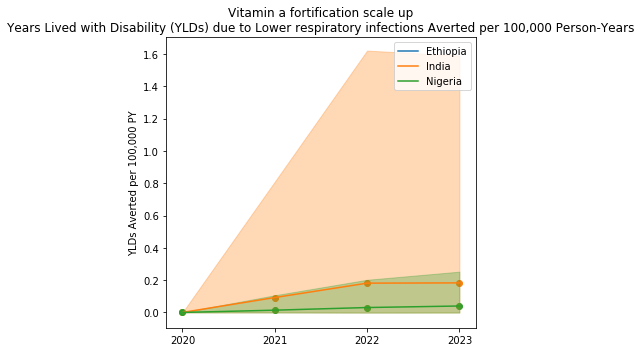

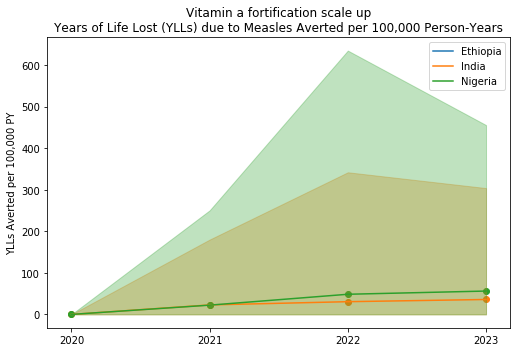

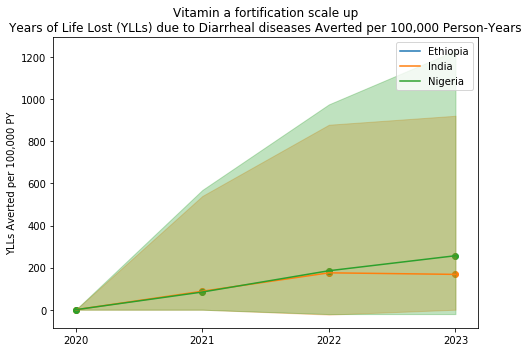

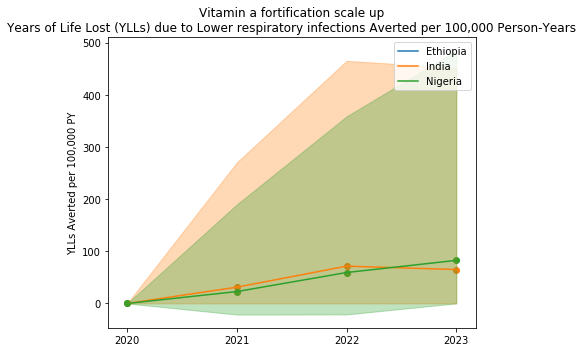

In [35]:
# VITAMIN A AFFECTED CAUSES YLDs and YLLs

scenarios = ['vitamin_a_fortification_scale_up']
causes = ['measles','diarrheal_diseases','lower_respiratory_infections']
outcome_vars = ['ylds','ylls']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

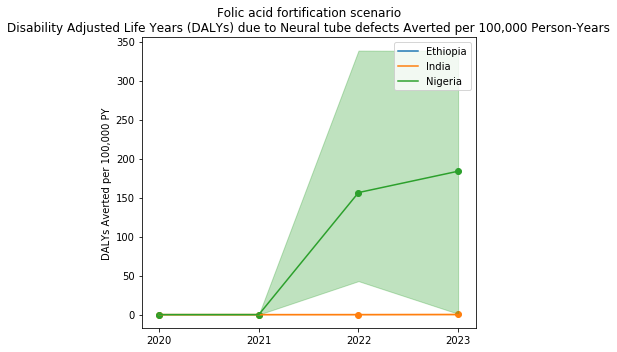

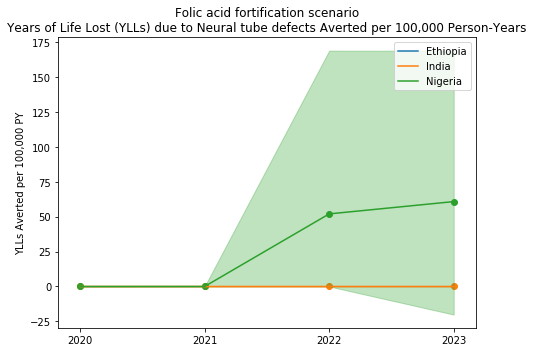

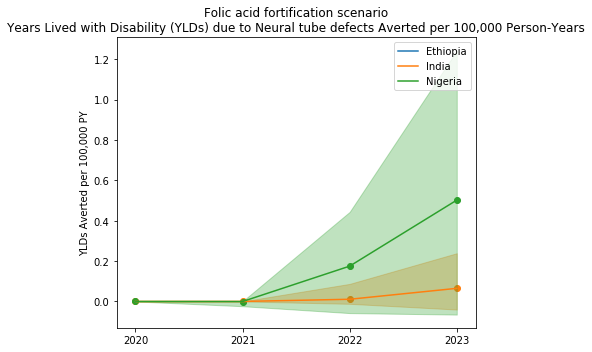

In [36]:
# FOLIC ACID NTD AVERTED DALYS, YLLs, YLDs

scenarios = ['folic_acid_fortification_scenario']
causes = ['neural_tube_defects']
outcome_vars = ['dalys','ylls','ylds']
make_multiple_plots_by_year_and_cause(by_year_and_cause, scenarios, causes, outcome_vars)

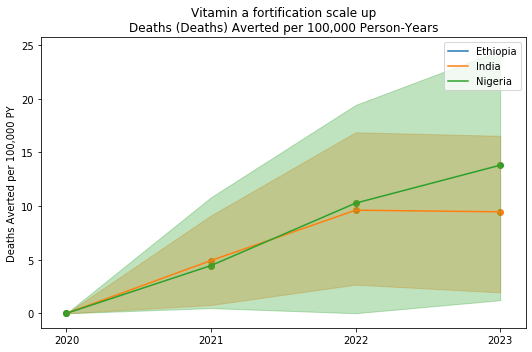

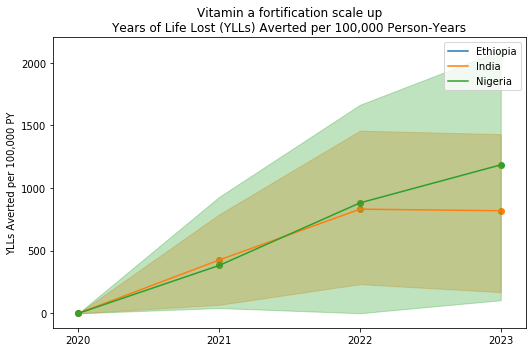

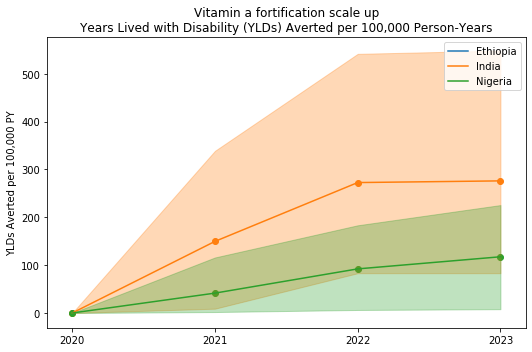

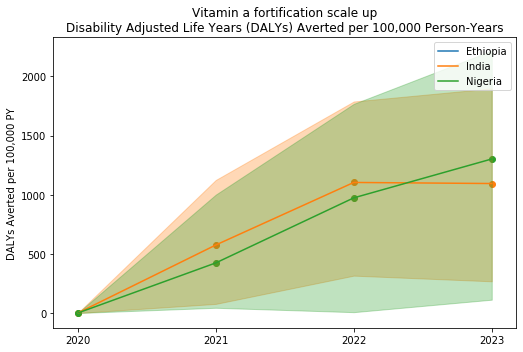

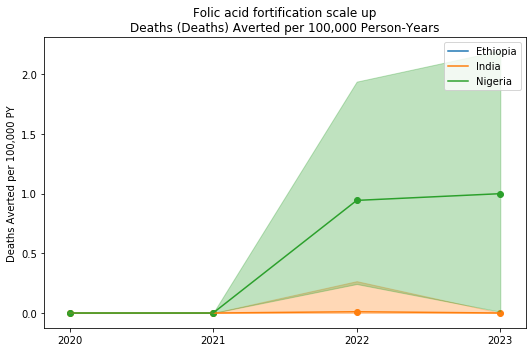

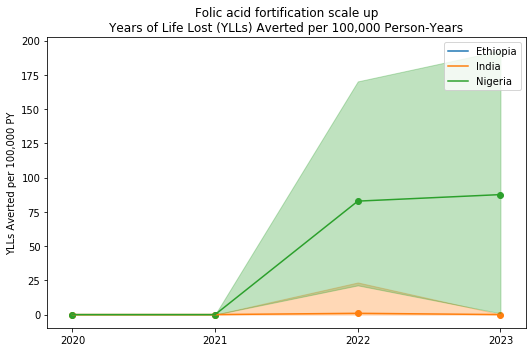

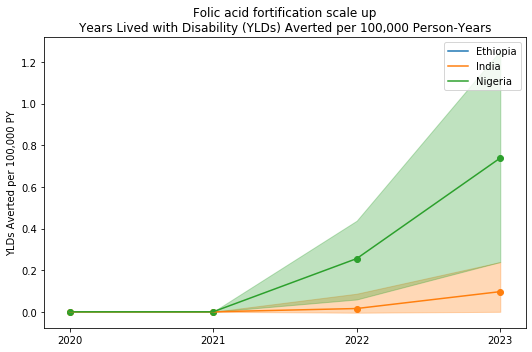

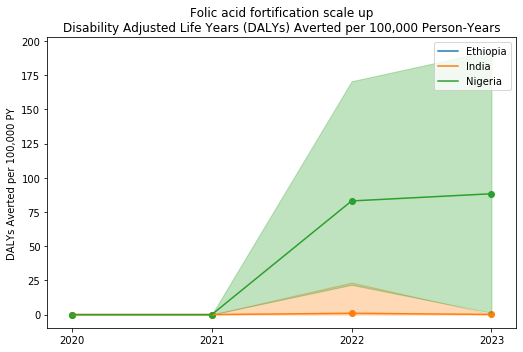

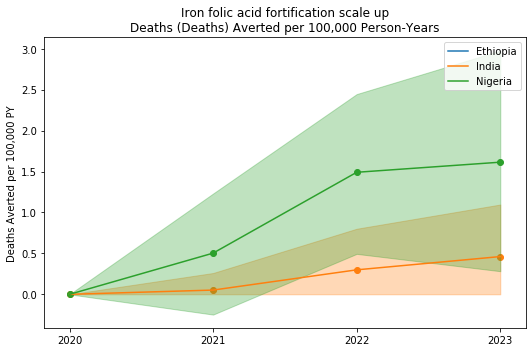

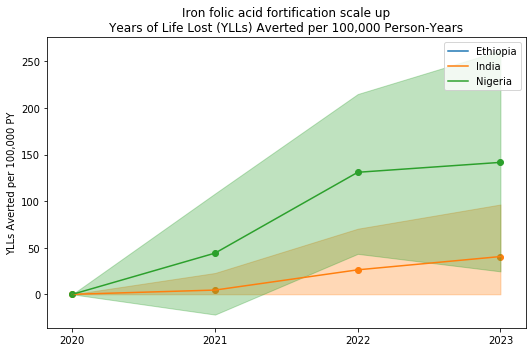

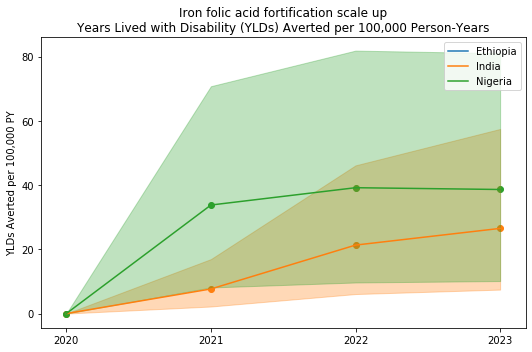

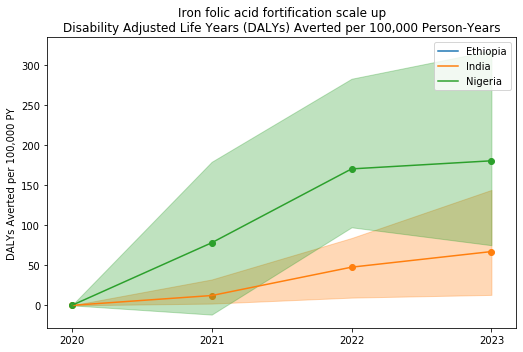

In [37]:
scenarios = ['vitamin_a_fortification_scale_up',
             'folic_acid_fortification_scale_up',
             'iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_plots_by_year_with_uncertainty(by_year, scenarios, outcome_vars)

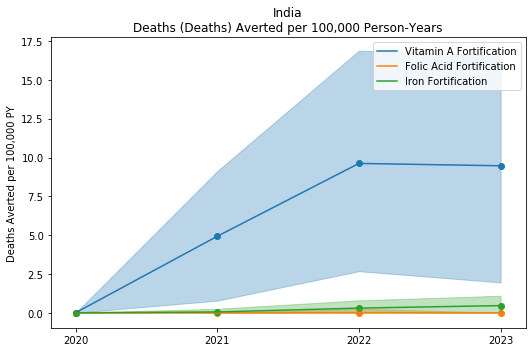

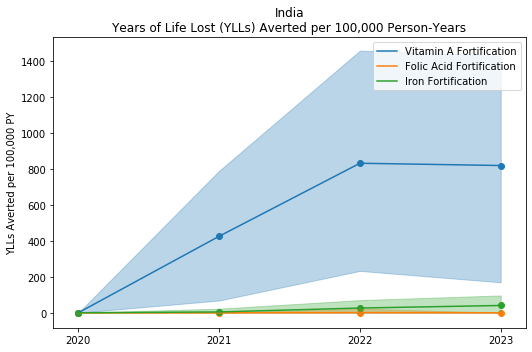

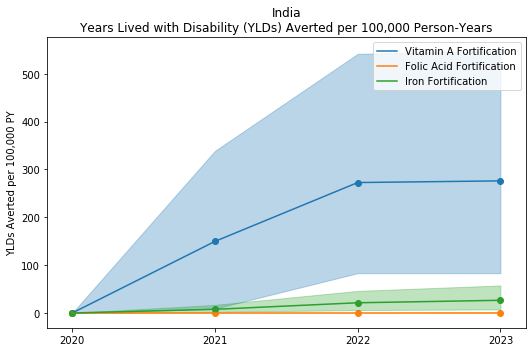

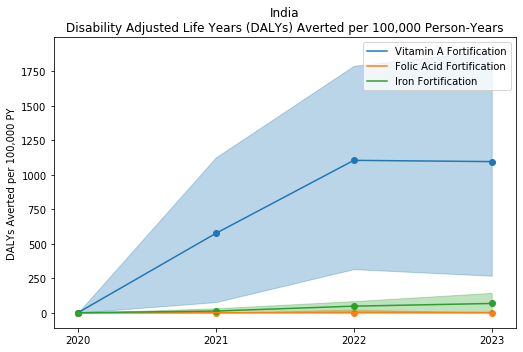

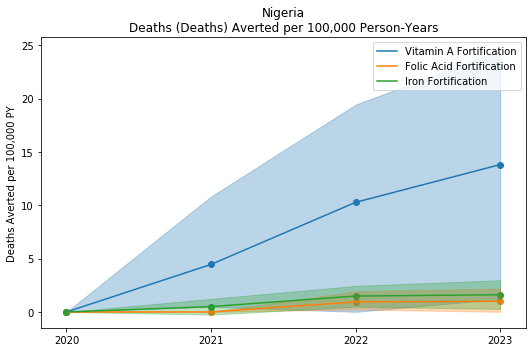

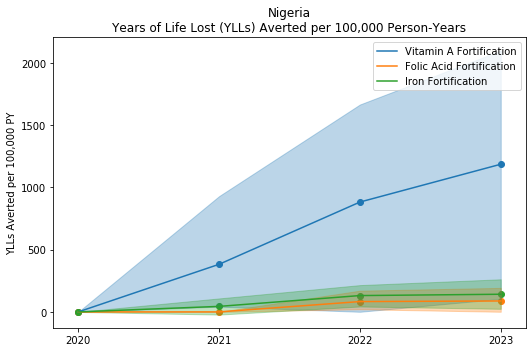

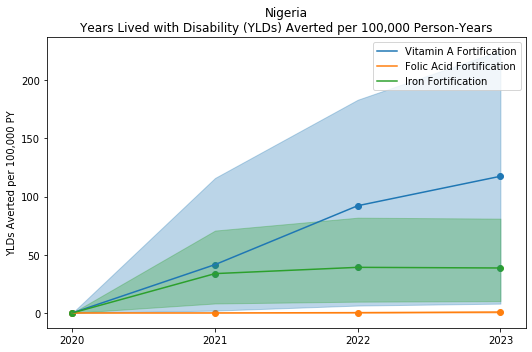

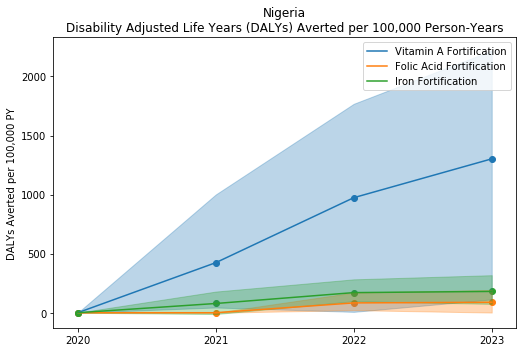

In [38]:
locations = ['India',
             'Nigeria']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_plots_by_year_by_location(by_year, locations, outcome_vars)

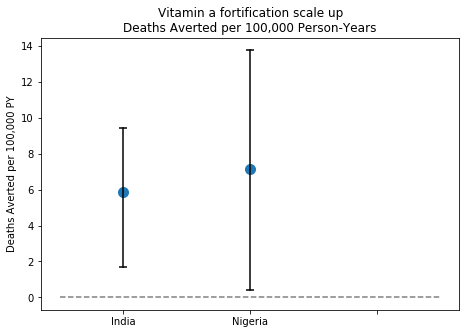

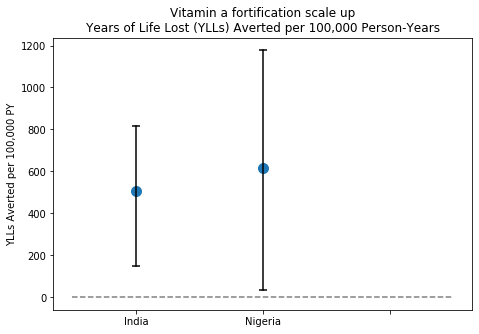

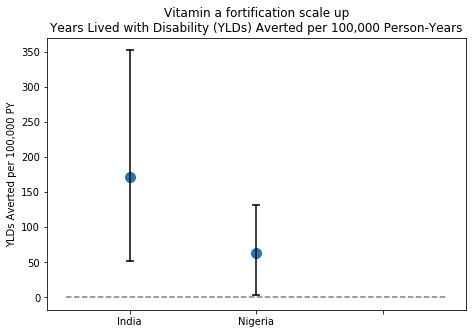

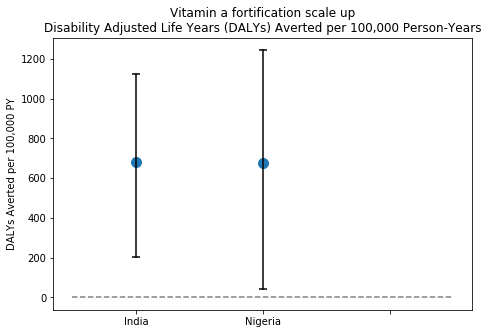

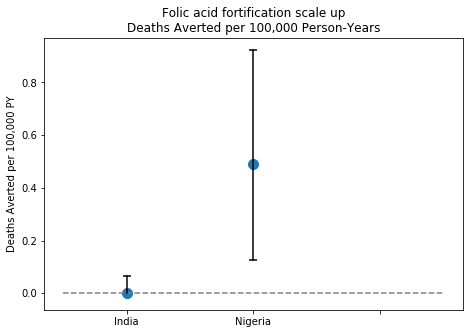

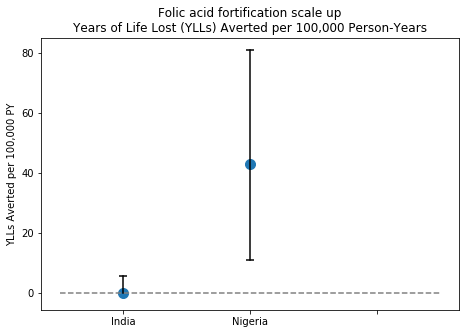

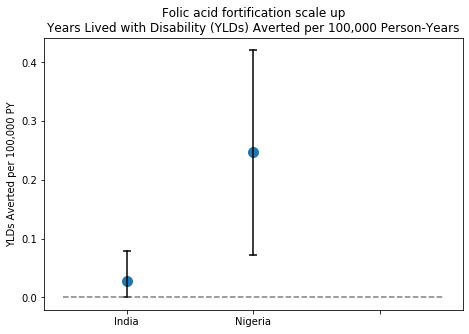

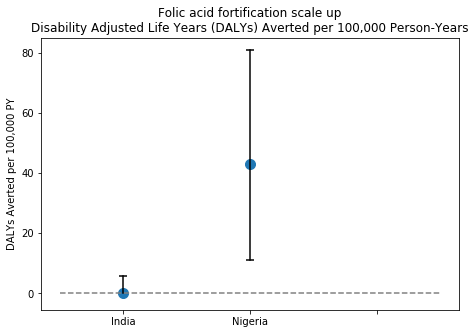

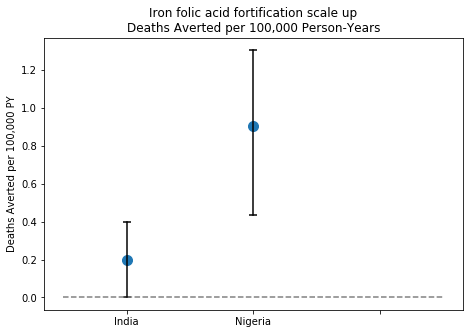

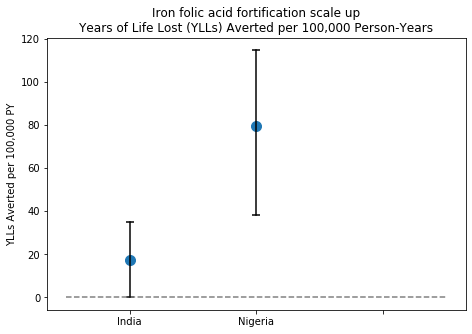

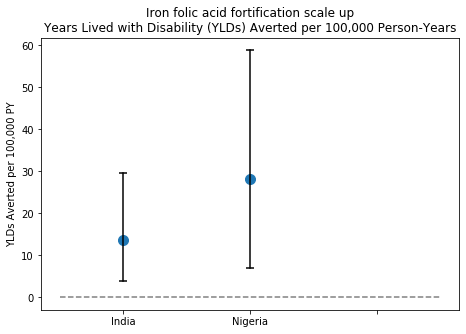

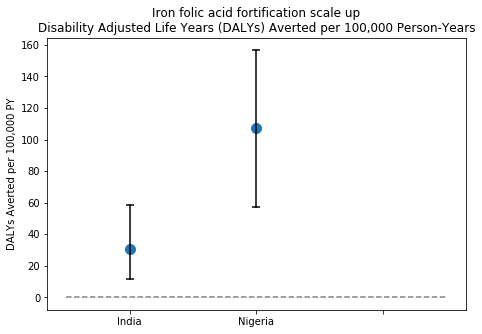

In [39]:
scenarios = ['vitamin_a_fortification_scale_up','folic_acid_fortification_scale_up',
            'iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths','ylls','ylds','dalys']

make_multiple_dot_plots(overall, scenarios, outcome_vars)

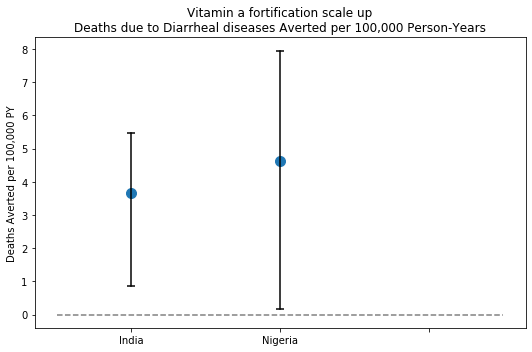

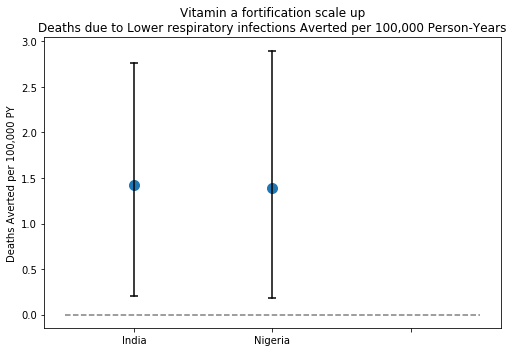

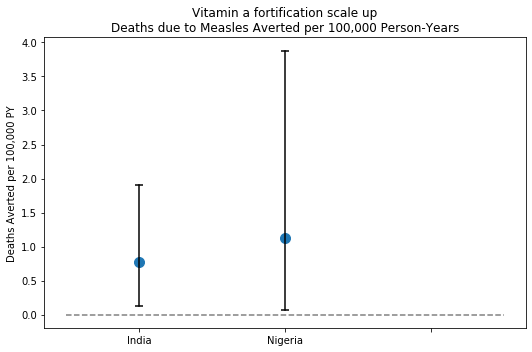

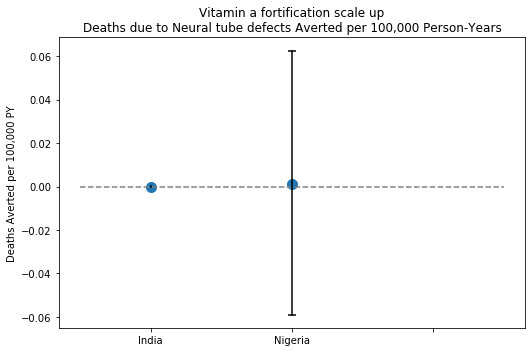

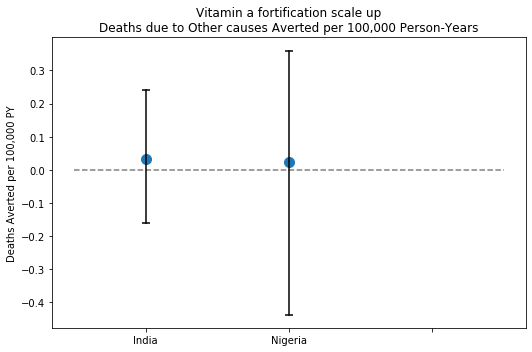

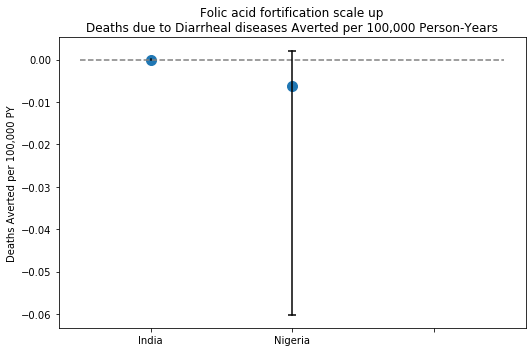

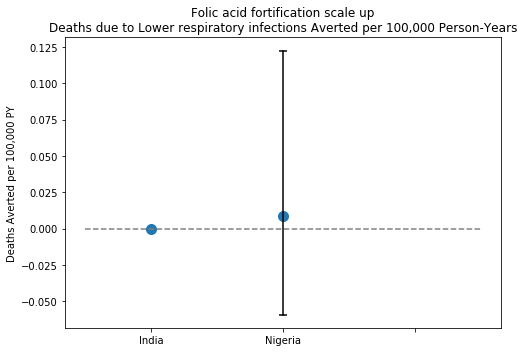

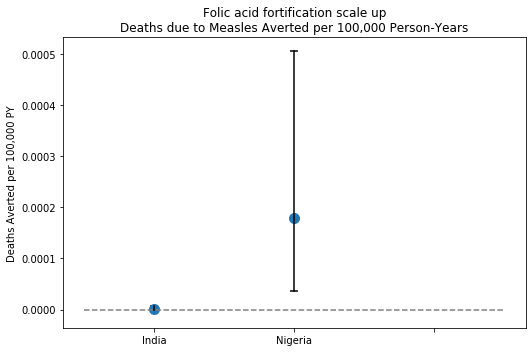

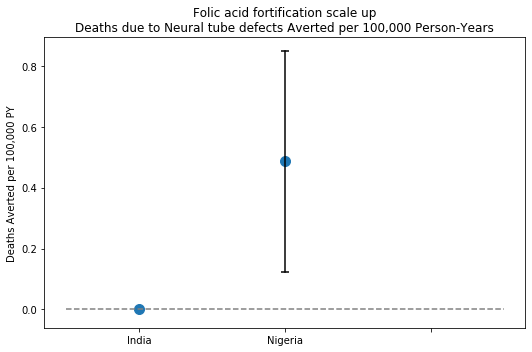

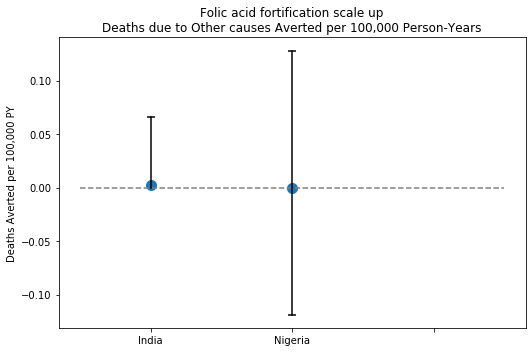

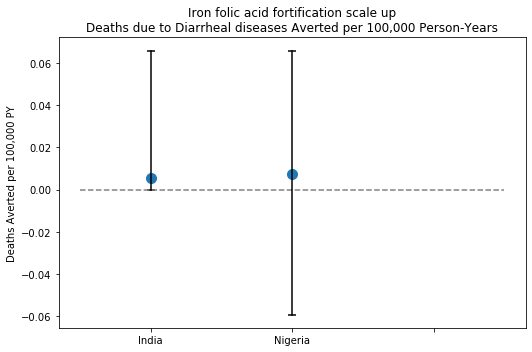

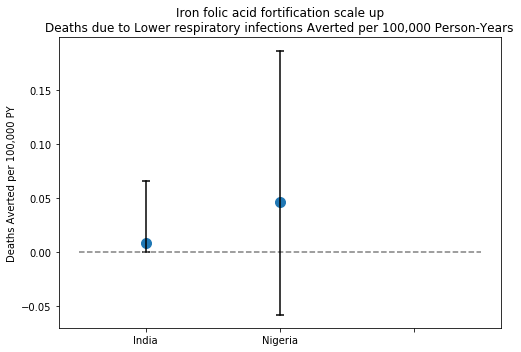

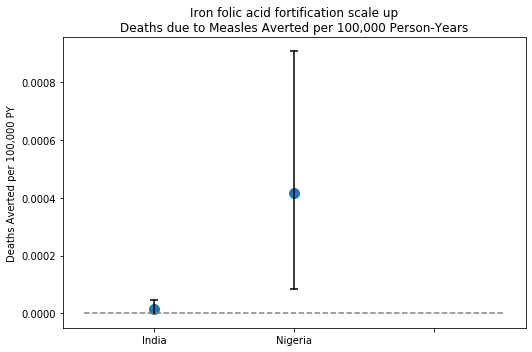

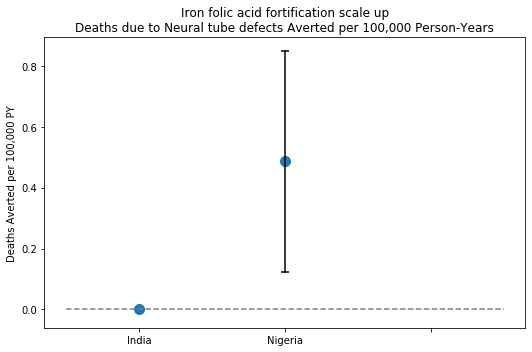

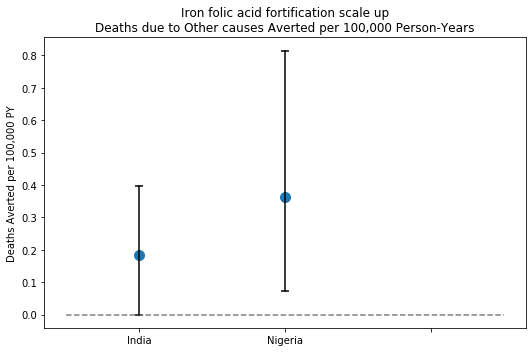

In [40]:
# AVERTED OUTCOMES BY CAUSE (OVERALL ACROSS YEARS)

scenarios = ['vitamin_a_fortification_scale_up','folic_acid_fortification_scale_up','iron_folic_acid_fortification_scale_up']

outcome_vars = ['deaths']

causes = ['diarrheal_diseases',
       'lower_respiratory_infections', 'measles', 'neural_tube_defects',
       'other_causes']

plot_results_by_cause(by_cause, scenarios, outcome_vars, causes)